In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import geoplot
import shapely
import pysal
import matplotlib.pyplot as plt
%matplotlib inline


/home/ja/miniconda3/envs/map/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


Create some random XY points between 0 and 100 in each dimension, and plot for fun

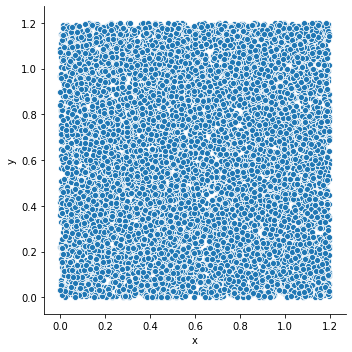

In [3]:
# constat data gen variables
total_points = 10000
knn_for_data_gen = 30

# generate random location of points
xy = 1.2 * np.random.rand(total_points,2)
xydf = pd.DataFrame(data=xy)
xydf.columns = ['x', 'y']

# standard normal errors for each point
errors_ind = np.random.normal(0, 1, total_points)
xydf["errors"] = errors_ind

# an identiy matrix needed for generating simulated values at each point
I = np.identity(total_points)

# plotting the points
sns.relplot(x="x", y="y", data=xydf);

Generate a spatial weights matrix for the points based on $k$ nearest neighbours

In [4]:
# weights matrix for k nearest
kd = pysal.lib.cg.kdtree.KDTree(xy)
W = pysal.lib.weights.KNN(kd, knn_for_data_gen)
W.transform = 'r' # row normalizing

# extract the sparse weights matrix as a full np array for matrix multiplication
W = (W.sparse)
W = (W.toarray())

Pick a $\rho$ for generating spatiall correlated values at each point, then run spatial autoregressive process

In [5]:
rho = 0.9

$Y = (I - \rho W)^{-1} \epsilon$

In [6]:
%%time 
Y = np.matrix(I - rho * W).I.dot(errors_ind)

CPU times: user 1min 10s, sys: 2.74 s, total: 1min 13s
Wall time: 34 s


In [7]:
# append these Y values to the point data frame
xydf["sim"] = np.transpose(Y)

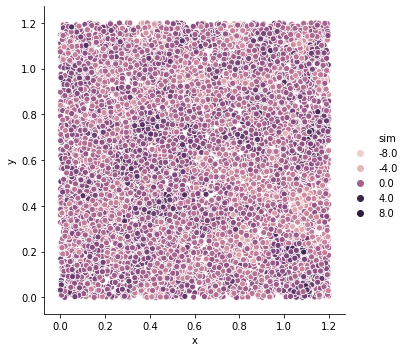

In [8]:
# plot if we want to see the points with colours
sns.relplot(x="x", y="y", hue="sim",data=xydf);

In [9]:
# also convert these Y values to a binary (1,0) if we want to analyze zonal proportions (where mean = 0.5)
simmean = xydf["sim"].mean()
xydf['sim_b'] = 0
xydf['sim_b'][xydf['sim'] > simmean] = 1

/home/ja/miniconda3/envs/map/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [10]:
# add in binomial distribution for whether observation is sampled or not, 
# do this for several sampling rates [0.03,0.05,0.1,0.2,0.5,1.0]
xydf["sample_03"] = np.random.binomial(1, 0.03, size=total_points)
xydf["sample_05"] = np.random.binomial(1, 0.05, size=total_points)
xydf["sample_10"] = np.random.binomial(1, 0.10, size=total_points)
xydf["sample_20"] = np.random.binomial(1, 0.20, size=total_points)
xydf["sample_50"] = np.random.binomial(1, 0.50, size=total_points)
xydf["sample_100"] = np.random.binomial(1, 1, size=total_points) 

In [11]:
# load in grid data (was generated in QGIS by hand)
grid_6 = gpd.read_file("grids/grid_6x6.geojson")
grid_8 = gpd.read_file("grids/grid_8x8.geojson")
grid_10 = gpd.read_file("grids/grid_10x10.geojson")
grid_12 = gpd.read_file("grids/grid_12x12.geojson")
grid_15 = gpd.read_file("grids/grid_15x15.geojson")

Loop over each sample size `["3%","5%","10%","20%","50%","100%"]`

and then over each grid size `["6x6","8x8","10x10","12x12","15x15"]`

Aggregating the sampled points to each grid cell.

Computing global spatial autocorrelation stats

And plotting simple choropleths of each to show how results vary



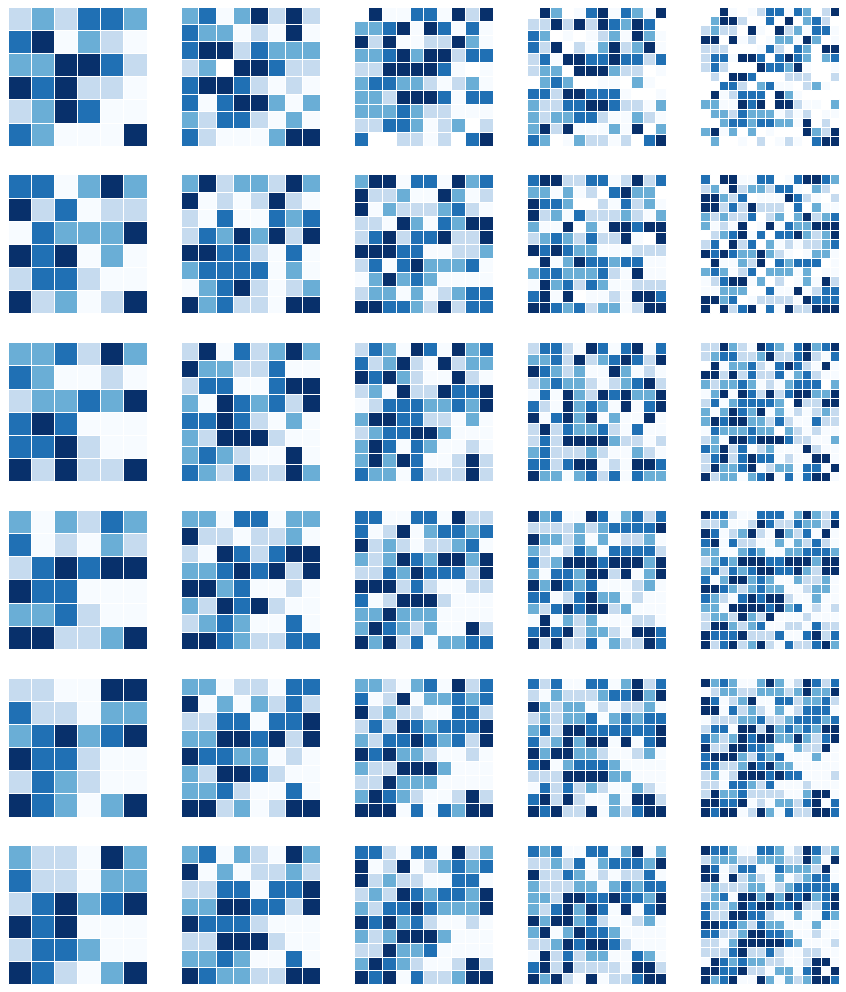

In [14]:
## include plotting info (comment out if not plotting)
f, axarr = plt.subplots(6, 5, figsize=(15, 18))

samples = ["sample_03","sample_05","sample_10","sample_20","sample_50","sample_100"]
sample_names = ["3%","5%","10%","20%","50%","100%"]
grids = [grid_6, grid_8, grid_10, grid_12, grid_15]
grid_names = ["6x6","8x8","10x10","12x12","15x15"]

outputs = []

s = 0
for sample in samples:
        
    # subset data by each sample
    xydf_s = xydf.loc[(xydf[sample] == 1)]
    
    # set up a geodataframe for this, to allow for future spatial join
    geometry = [shapely.geometry.Point(xy) for xy in zip(xydf_s.x, xydf_s.y)]
    gdf = gpd.GeoDataFrame(xydf_s,  geometry=geometry)
    
    g = 0
    for grid in grids:
                
        # spatial join the grid IDs to the point data
        xy_with_grid = gpd.sjoin(gdf, grid, how="inner", op='intersects')

        # generate means and proportions in each cell of the grid
        grid_desc = xy_with_grid.groupby(['id']).agg({'errors': "count",'sim': "mean",  'sim_b': "sum"})
        
        # update some of the column names
        grid_desc["mean"] = grid_desc["sim"]
        grid_desc["prop"] = grid_desc["sim_b"] / grid_desc["errors"]
        del grid_desc['sim'], grid_desc['sim_b'], grid_desc['errors']
        
        # join back to grid boundaries
        grid_join = grid.merge(grid_desc, on='id')
        
        # compute spatial weights matrix
        Wg = pysal.lib.weights.Queen.from_dataframe(grid_join)
        Wg.transform = 'r' # row normalizing

        mi = pysal.explore.esda.Moran(np.array(grid_join["mean"]), Wg, two_tailed=False)

        grid_join["var"] = np.random.normal(0, 1, len(grid_join))
        #YVar='mean'
        #XVars=['id'] 
        Ym=grid_join['mean'].values.reshape((len(grid_join),1))
        Xm=grid_join[['var']].values
        mlag = pysal.model.spreg.ml_lag.ML_Lag(Ym,Xm,w=Wg,name_y='mean', name_x=['var'] )
        
        # output the values
        output = [sample_names[s], grid_names[g], round(mi.I, 3), round(mi.p_norm, 3), round(mlag.rho,3),  round(mlag.z_stat[2][1],3)]
        outputs.append(output)
        
       
        geoplot.choropleth(
            grid_join, hue='mean',
            edgecolor='white', linewidth=1,
            cmap='Blues', legend=False,
            scheme='quantiles', figsize=(2, 2),
            ax=axarr[s][g]
        )
        
        g += 1

    s += 1

In [20]:
outputs

[['3%', '6x6', 0.068, 0.142, 0.125, 0.638],
 ['3%', '8x8', 0.119, 0.023, 0.343, 0.054],
 ['3%', '10x10', 0.161, 0.001, 0.419, 0.002],
 ['3%', '12x12', 0.162, 0.0, 0.396, 0.001],
 ['3%', '15x15', 0.213, 0.0, 0.421, 0.0],
 ['5%', '6x6', -0.061, 0.36, -0.174, 0.559],
 ['5%', '8x8', 0.112, 0.028, 0.335, 0.064],
 ['5%', '10x10', 0.12, 0.008, 0.311, 0.04],
 ['5%', '12x12', 0.156, 0.0, 0.426, 0.0],
 ['5%', '15x15', 0.16, 0.0, 0.378, 0.0],
 ['10%', '6x6', -0.017, 0.446, -0.047, 0.871],
 ['10%', '8x8', 0.103, 0.039, 0.355, 0.043],
 ['10%', '10x10', 0.18, 0.0, 0.477, 0.0],
 ['10%', '12x12', 0.201, 0.0, 0.497, 0.0],
 ['10%', '15x15', 0.237, 0.0, 0.537, 0.0],
 ['20%', '6x6', 0.036, 0.235, 0.074, 0.783],
 ['20%', '8x8', 0.098, 0.045, 0.294, 0.115],
 ['20%', '10x10', 0.156, 0.001, 0.419, 0.002],
 ['20%', '12x12', 0.23, 0.0, 0.566, 0.0],
 ['20%', '15x15', 0.267, 0.0, 0.602, 0.0],
 ['50%', '6x6', -0.048, 0.413, -0.16, 0.59],
 ['50%', '8x8', 0.094, 0.05, 0.295, 0.114],
 ['50%', '10x10', 0.2, 0.0, 0.535

In [19]:
grid_join.head()

,left,top,right,bottom,id,geometry,mean,prop,var
0,0.0,1.20,0.08,1.12,1,"POLYGON ((0 1.2, 0.08 1.2, 0.08 1.12, 0 1.12, ...",0.525041,0.807692,-0.505755
1,0.0,1.12,0.08,1.04,2,"POLYGON ((0 1.12, 0.08 1.12, 0.08 1.04, 0 1.04...",0.341113,0.688889,-0.375544
2,0.0,1.04,0.08,0.96,3,"POLYGON ((0 1.04, 0.08 1.04, 0.08 0.96, 0 0.96...",-1.521892,0.130435,1.678035
3,0.0,0.96,0.08,0.88,4,"POLYGON ((0 0.96, 0.08 0.96, 0.08 0.88, 0 0.88...",-3.251494,0.000000,0.665845
4,0.0,0.88,0.08,0.80,5,"POLYGON ((0 0.88, 0.08 0.88, 0.08 0.8, 0 0.8, ...",-2.330454,0.055556,0.157667
